In [1]:
from watson_developer_cloud import NaturalLanguageUnderstandingV1
from watson_developer_cloud.natural_language_understanding_v1 import Features, EntitiesOptions, KeywordsOptions, SentimentOptions, CategoriesOptions
import re
from unicodedata import normalize
import pandas as pd
import string

# Lectura de los datos

In [2]:
path_train="../../jigsaw-unintended-bias-in-toxicity-classification/train_split01.csv"
df_train = pd.read_csv(path_train)

In [3]:
# Selección de las columnas de interes
df_train_samp=df_train[['target', 'comment_text']]
#Para poder realizar un análsis equivalente al del Español, tomamos 600 comentarios
df_train_samp=df_train_samp.iloc[1:600, :]

# Definición del método y las variables para llamar a la API de IBM Watson

In [4]:
import yaml

IBM_CONFIG_FILE = '../../auth-IBM/auth.yaml'

with open(IBM_CONFIG_FILE, 'r') as config_file:
    config = yaml.load(config_file)
    
print(type(config))

<class 'dict'>


In [5]:
nlu = NaturalLanguageUnderstandingV1(                                         
    version='2018-11-16',
    iam_apikey=config['IBM']['iam_apikey'], 
    url='https://gateway-lon.watsonplatform.net/natural-language-understanding/api' 
    )



def analisis_sentimiento(input_text): 
    response = nlu.analyze (text = input_text,
    features = Features(sentiment=SentimentOptions()), language='es').get_result()
    # De la salida se obtiene un número entre -1 y 1
    res = response.get('sentiment').get('document').get('score')
    return res

C:\Users\Esperanza\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: DeprecationWarning: watson-developer-cloud moved to ibm-watson. To get updates, use the new package.
  after removing the cwd from sys.path.


In [32]:
#Analizamos cada uno de los comentarios añadiendo una columna con los resultados
df_train_samp['neg_IBMW']=df_train_samp.loc[:,'comment_text'].map(lambda txt: str(analisis_sentimiento(txt)) )

In [33]:
#Se etiqueta como 1 el flag indicativo del comentario tóxico. 
def is_toxic(floatnum):
    res=2
    if floatnum>=0:  
        res=0
    elif floatnum <0: 
        res=1
    return res

In [36]:
df_train_samp.neg_IBMW2=df_train_samp.neg_IBMW.map(lambda x: is_toxic(float(x)))
df_train_samp.neg_IBMW2.unique()

C:\Users\Esperanza\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  """Entry point for launching an IPython kernel.


array([0, 1], dtype=int64)

In [25]:
#Redondeo del target de kaggle como tóxico cuando es >0.5 y no tóxico cuando es menor que 0.5
df_train_samp.target=df_train_samp.target.astype(float).round().astype(int)


In [30]:
df_train_samp.neg_IBMW.unique()


array([0, '0', 1], dtype=object)

In [37]:
from sklearn.metrics import confusion_matrix

cm=confusion_matrix(df_train_samp.target, df_train_samp.neg_IBMW2)
cm

array([[307,  64],
       [ 10,   5]], dtype=int64)

In [38]:

def plot_confusion_matrix(cm,
                          target_names,
                          title='Confusion matrix',
                          cmap=None,
                          normalize=True):
    """
    given a sklearn confusion matrix (cm), make a nice plot

    Arguments
    ---------
    cm:           confusion matrix from sklearn.metrics.confusion_matrix

    target_names: given classification classes such as [0, 1, 2]
                  the class names, for example: ['high', 'medium', 'low']

    title:        the text to display at the top of the matrix

    cmap:         the gradient of the values displayed from matplotlib.pyplot.cm
                  see http://matplotlib.org/examples/color/colormaps_reference.html
                  plt.get_cmap('jet') or plt.cm.Blues

    normalize:    If False, plot the raw numbers
                  If True, plot the proportions

    Usage
    -----
    plot_confusion_matrix(cm           = cm,                  # confusion matrix created by
                                                              # sklearn.metrics.confusion_matrix
                          normalize    = True,                # show proportions
                          target_names = y_labels_vals,       # list of names of the classes
                          title        = best_estimator_name) # title of graph

    Citiation
    ---------
    http://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html

    """
    import matplotlib.pyplot as plt
    import numpy as np
    import itertools

    accuracy = np.trace(cm) / float(np.sum(cm))
    misclass = 1 - accuracy

    if cmap is None:
        cmap = plt.get_cmap('Blues')

    plt.figure(figsize=(8, 6))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()

    if target_names is not None:
        tick_marks = np.arange(len(target_names))
        plt.xticks(tick_marks, target_names, rotation=45)
        plt.yticks(tick_marks, target_names)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]


    thresh = cm.max() / 1.5 if normalize else cm.max() / 2
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        if normalize:
            plt.text(j, i, "{:0.4f}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")
        else:
            plt.text(j, i, "{:,}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")


    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label\naccuracy={:0.4f}; misclass={:0.4f}'.format(accuracy, misclass))
    plt.show()
    
#fuente: https://www.kaggle.com/grfiv4/plot-a-confusion-matrix

C:\Users\Esperanza\Anaconda3\lib\site-packages\numpy\lib\type_check.py:546: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  'a.item() instead', DeprecationWarning, stacklevel=1)
C:\Users\Esperanza\Anaconda3\lib\site-packages\numpy\lib\type_check.py:546: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  'a.item() instead', DeprecationWarning, stacklevel=1)
C:\Users\Esperanza\Anaconda3\lib\site-packages\numpy\lib\type_check.py:546: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  'a.item() instead', DeprecationWarning, stacklevel=1)
C:\Users\Esperanza\Anaconda3\lib\site-packages\numpy\lib\type_check.py:546: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  'a.item() instead', DeprecationWarning, stacklevel=1)


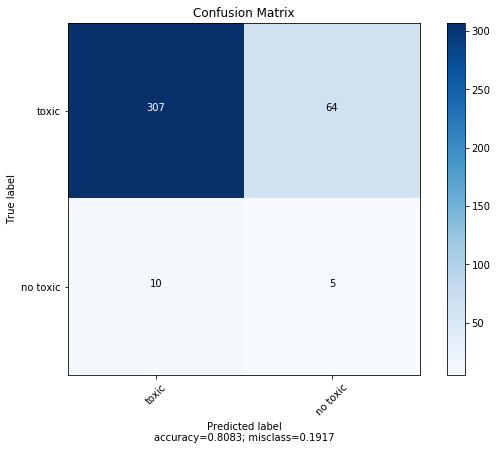

In [40]:
plot_confusion_matrix(cm,
                      normalize    = False,
                      target_names = ['toxic', 'no toxic'],
                      title        = "Confusion Matrix")